## Steps in building a machine learning model

1. Get the Data
2. Data Check
3. Split the Data (Train/Validation/Test)
4. EDA and Feature Importance
5. Training and model selection
6. Select a Final Model
7. Final model evaluation

It has to change the path of the data according to the location of the folder of the repo.

### 1. Get the Data

The information about the data set is in the "01 Data" folder. Check for the description of the columns.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import ast

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler


# import warnings
# warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r'/Users/fdl/Repos/ML-ZoomCamp-Capstone-project-3/01 Data/cleaned_data.csv')

df.columns

Index(['model', 'price', 'rating', 'os', 'sim_type', 'network_type', 'VoLTE',
       'NFC', 'ir_blaster', 'chipset', 'core_type', 'clock_ghz', 'ram_gb',
       'storage_gb', 'battery_mah', 'fast_charge_w', 'screen_size_in',
       'resolution', 'refresh_rate_hz', 'display_type', 'rear_camera_mp_list',
       'rear_camera_count', 'rear_camera_max_mp', 'front_camera_mp',
       'memory_card_supported', 'memory_card_type', 'memory_card_max_gb'],
      dtype='object')

### 2. Data Check

Exploration of the dataset (values for the different types of variables, missing values, max and min values).

In [3]:
# We can see if there are missing values and data types
# There are missing values in this dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 968 entries, 0 to 967
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   model                  968 non-null    object 
 1   price                  968 non-null    int64  
 2   rating                 968 non-null    float64
 3   os                     942 non-null    object 
 4   sim_type               968 non-null    object 
 5   network_type           968 non-null    object 
 6   VoLTE                  968 non-null    bool   
 7   NFC                    968 non-null    bool   
 8   ir_blaster             968 non-null    bool   
 9   chipset                968 non-null    object 
 10  core_type              962 non-null    object 
 11  clock_ghz              927 non-null    float64
 12  ram_gb                 968 non-null    int64  
 13  storage_gb             968 non-null    int64  
 14  battery_mah            957 non-null    float64
 15  fast_c

As we can see, we have some columns like `refresh_rate_hz` or `memory_card_max_gb` with 40-50% of null values.

Some values we can fill multiple values ​​with logic.

In [4]:
# Num rows with Null 
total_nulls = df.isnull().sum().sum()
print(f"Total null values in the DataFrame: {total_nulls}")

# Num columns with Null
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

Total null values in the DataFrame: 1371


memory_card_max_gb    468
refresh_rate_hz       360
fast_charge_w         204
memory_card_type      127
display_type           85
clock_ghz              41
os                     26
front_camera_mp        25
rear_camera_max_mp     16
battery_mah            11
core_type               6
screen_size_in          1
resolution              1
dtype: int64

In [5]:
# we are going to create a new variable called brand to input some values according to the model

df['brand'] = df['model'].str.split(' ').str[0]
df['brand'].unique()

array(['oneplus', 'samsung', 'motorola', 'realme', 'apple', 'xiaomi',
       'nothing', 'oppo', 'vivo', 'poco', 'iqoo', 'jio', 'gionee',
       'tecno', 'tesla', 'google', 'infinix', 'cola', 'letv', 'ikall',
       'leeco', 'duoqin', 'nokia', 'lava', 'honor', 'nubia', 'redmi',
       'asus', 'itel', 'royole', 'sony', 'oukitel', 'vertu', 'blu',
       'huawei', 'zte', 'lenovo', 'lg', 'micromax', 'leitz', 'cat',
       'doogee', 'tcl', 'sharp', 'blackview'], dtype=object)

1. Imputation for "Mode Group" (Categorical)

In [6]:
cat_cols_with_nan = ['os', 'core_type', 'display_type', 'memory_card_type']

for col in cat_cols_with_nan:
    # if the brand dont has mode, we fill with overall mode
    df[col] = df.groupby('brand')[col].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else df[col].mode()[0]))

2. Imputation for "Median Group" (Nemerical)

In [7]:
# Para clock_ghz y battery_mah
# We can't give a $200 USD phone the same clock speed (clock_GHz) as a $1,200 USD phone. 
# Here we segment by brand and, optionally, we could create price bins.
num_cols_to_group = ['clock_ghz', 'battery_mah', 'front_camera_mp', 'rear_camera_max_mp']

for col in num_cols_to_group:
    df[col] = df.groupby('brand')[col].transform(lambda x: x.fillna(x.median() if x.notna().any() else df[col].median()))

3. Special Case: `memory_card_max_gb`

In [8]:
# we are going to see how many values we can imput with variable memory_card_supported

# First: if there is no SD, extra capacity is 0
df.loc[df['memory_card_supported'] == 0, 'memory_card_max_gb'] = 0
    
df['memory_card_max_gb'].isnull().sum()

np.int64(468)

In [9]:
# Second: we are going to imput the rest of nulls with median of brand
df['memory_card_max_gb'] = df.groupby('brand')['memory_card_max_gb'].transform(lambda x: x.fillna(x.median() if x.notna().any() else df['memory_card_max_gb'].median()))

4. Business logic

In [10]:
# fast_charge_w: If it's zero, the phone most likely doesn't support fast charging. Enter 0.
# refresh_rate_hz: Standard smartphones typically have a 60Hz refresh rate. A null here 
# likely indicates that it's not a marketable feature, so 60Hz is a safer bet than average.
df['fast_charge_w'] = df['fast_charge_w'].fillna(0)
df['refresh_rate_hz'] = df['refresh_rate_hz'].fillna(60)

5. Erase values for `screen_size_in` y `resolution`

In [11]:
df.dropna(subset=['screen_size_in', 'resolution'], inplace=True)

In [12]:
# Final check of nulls
columns_null = df.isnull().sum()[df.isnull().sum() > 0].index.tolist()
df[columns_null].info()

<class 'pandas.core.frame.DataFrame'>
Index: 967 entries, 0 to 967
Empty DataFrame


We are going to review values for variables

In [13]:
# Review columns data types
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
numerical_columns = list(df.dtypes[df.dtypes != 'object'].index)

# number of unique values in categorical columns
print("Number of unique values in categorical columns:")
df[categorical_columns].nunique()

Number of unique values in categorical columns:


model                  776
os                      35
sim_type                 2
network_type             2
chipset                240
core_type                4
resolution              84
display_type             5
rear_camera_mp_list    146
memory_card_type         2
brand                   45
dtype: int64

In [14]:
# different values in categorical columns
for column in categorical_columns:
    if df[column].nunique() > 10:
        print(f'Column: {column} has more than 10 unique values, skipping detailed value counts.')
        continue
    print(f'Column: {column}')
    print(df[column].value_counts())
    print('-----------------------')

Column: model has more than 10 unique values, skipping detailed value counts.
Column: os has more than 10 unique values, skipping detailed value counts.
Column: sim_type
sim_type
Dual      951
Single     16
Name: count, dtype: int64
-----------------------
Column: network_type
network_type
5g    544
4g    423
Name: count, dtype: int64
-----------------------
Column: chipset has more than 10 unique values, skipping detailed value counts.
Column: core_type
core_type
Octa Core    889
Hexa Core     43
Quad Core     34
Dual Core      1
Name: count, dtype: int64
-----------------------
Column: resolution has more than 10 unique values, skipping detailed value counts.
Column: display_type
display_type
Punch Hole          589
Water Drop Notch    314
Large Notch          34
Small Notch          24
Dual Punch Hole       6
Name: count, dtype: int64
-----------------------
Column: rear_camera_mp_list has more than 10 unique values, skipping detailed value counts.
Column: memory_card_type
memory_ca

In [15]:
# Summary statistics for numerical columns
df[numerical_columns].describe()

,price,rating,clock_ghz,ram_gb,storage_gb,battery_mah,fast_charge_w,screen_size_in,refresh_rate_hz,rear_camera_count,rear_camera_max_mp,front_camera_mp,memory_card_supported,memory_card_max_gb
count,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.0,967.000000
mean,32728.122027,78.559462,2.440000,7.641158,7.641158,4804.000000,36.547777,6.535998,92.478800,2.270941,50.682523,16.623578,1.0,793.786970
std,39724.379747,6.931216,0.466641,23.135582,23.135582,1019.470601,35.846766,0.381498,28.953295,0.902615,32.984179,10.802815,0.0,332.681408
min,2999.000000,60.000000,1.000000,1.000000,1.000000,1500.000000,0.000000,2.400000,60.000000,0.000000,2.000000,2.000000,1.0,32.000000
25%,12999.000000,75.000000,2.050000,4.000000,4.000000,4500.000000,15.000000,6.500000,60.000000,1.000000,48.000000,8.000000,1.0,512.000000
50%,19999.000000,80.000000,2.360000,6.000000,6.000000,5000.000000,30.000000,6.580000,90.000000,3.000000,50.000000,16.000000,1.0,1024.000000
75%,35744.500000,84.000000,2.840000,8.000000,8.000000,5000.000000,65.000000,6.670000,120.000000,3.000000,64.000000,16.000000,1.0,1024.000000
max,650000.000000,89.000000,3.220000,512.000000,512.000000,22000.000000,240.000000,8.030000,240.000000,4.000000,200.000000,60.000000,1.0,2048.000000


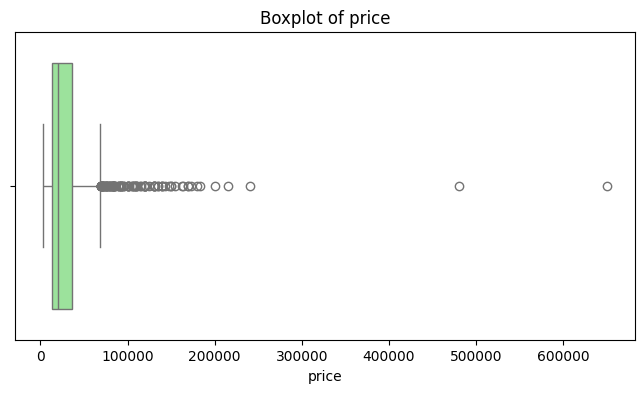

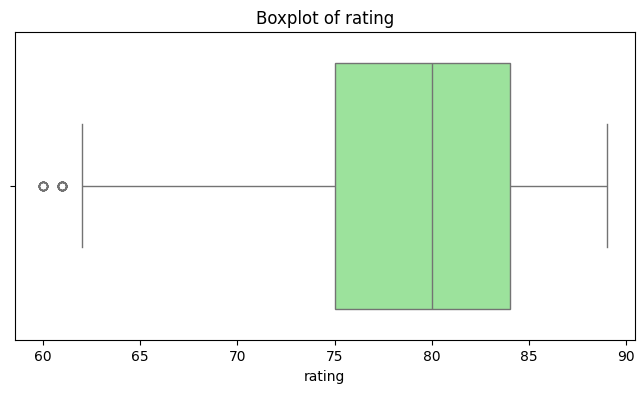

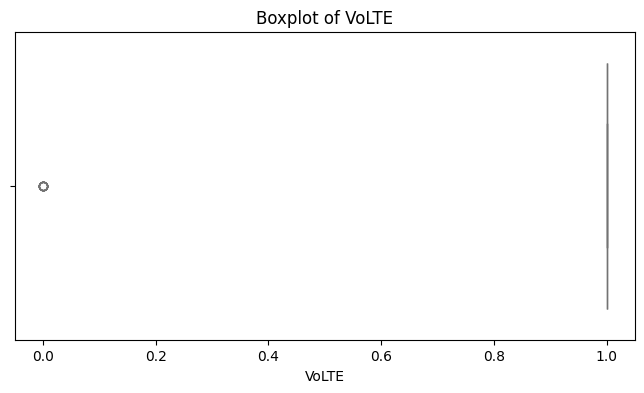

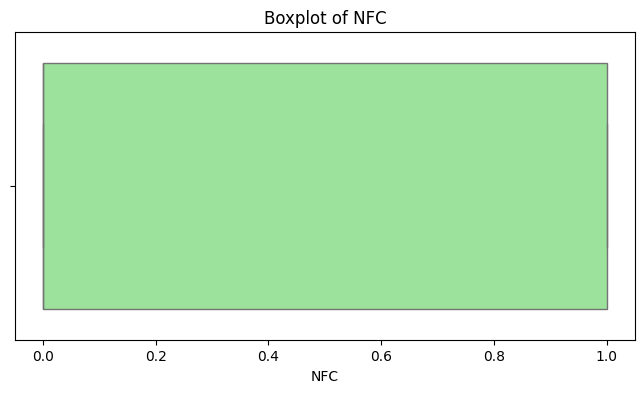

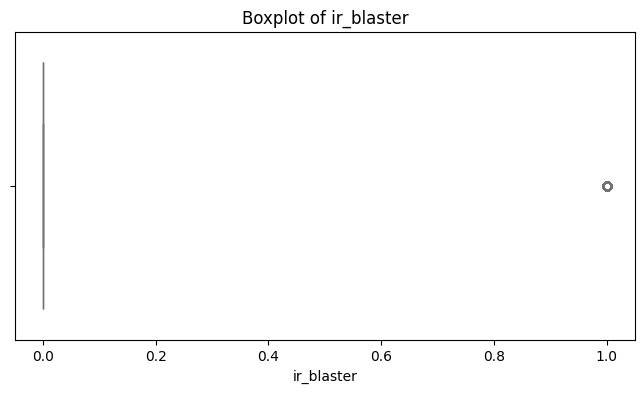

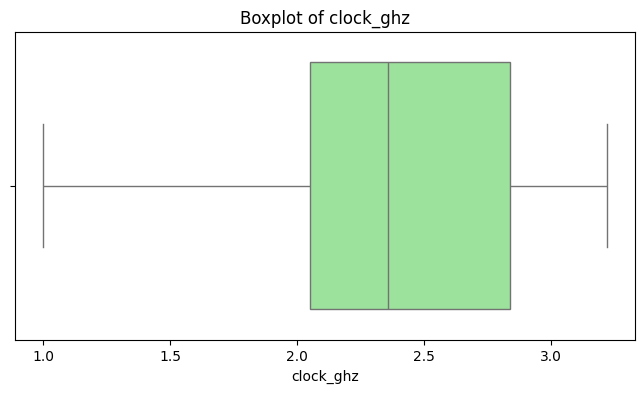

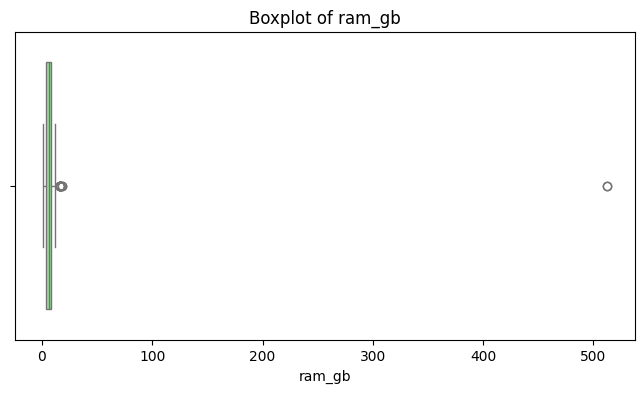

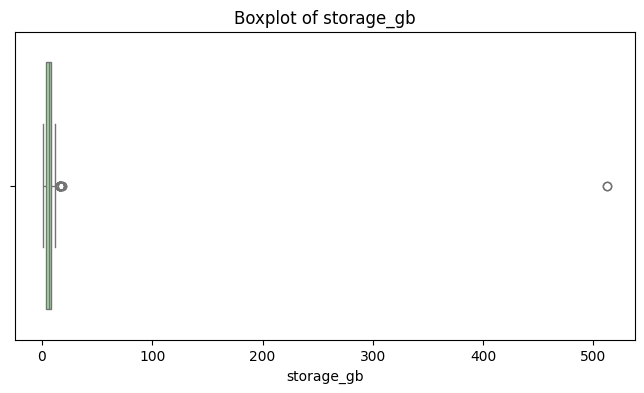

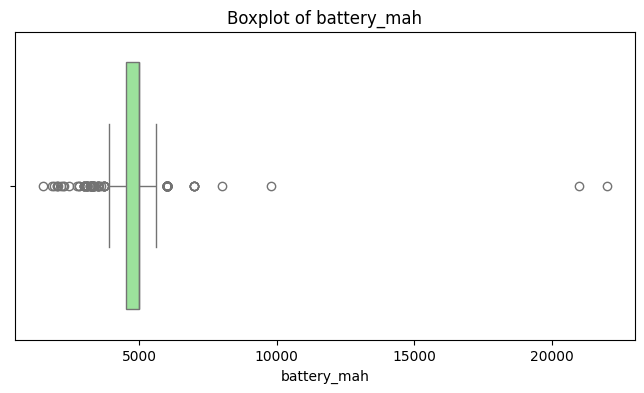

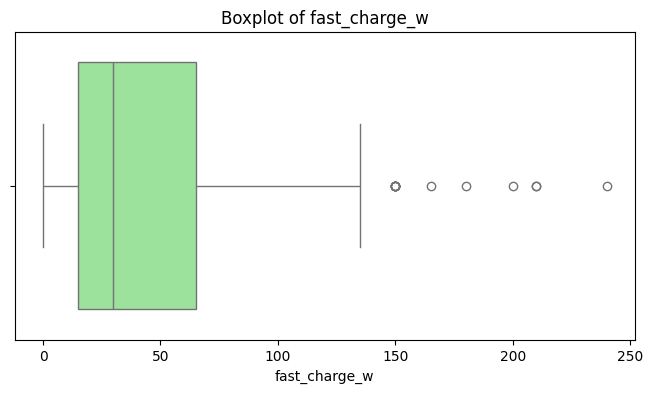

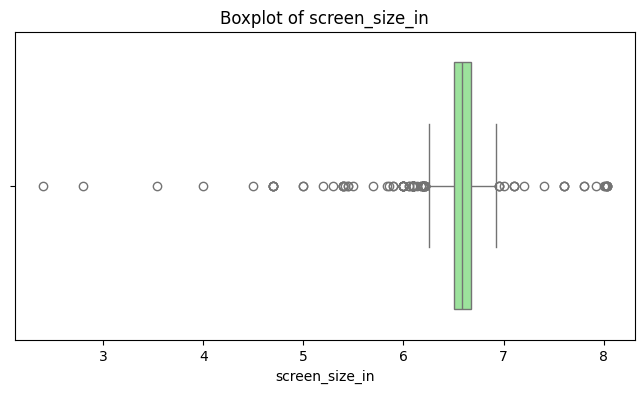

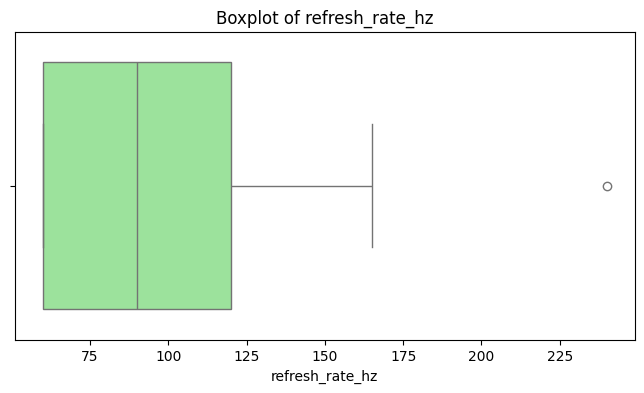

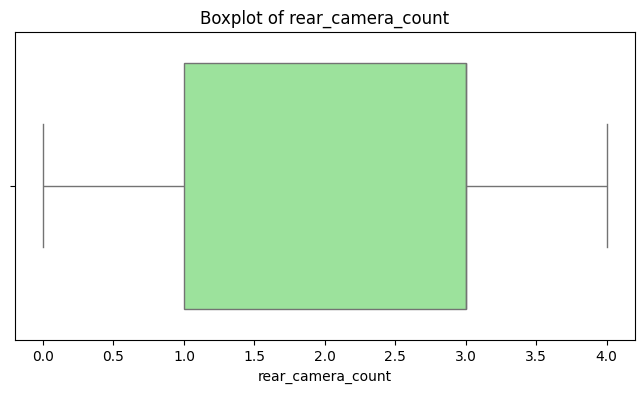

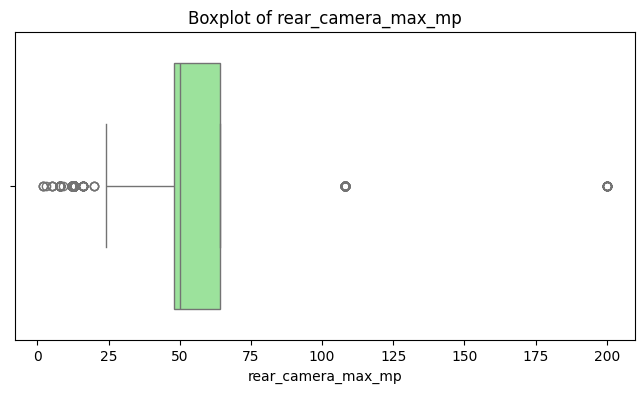

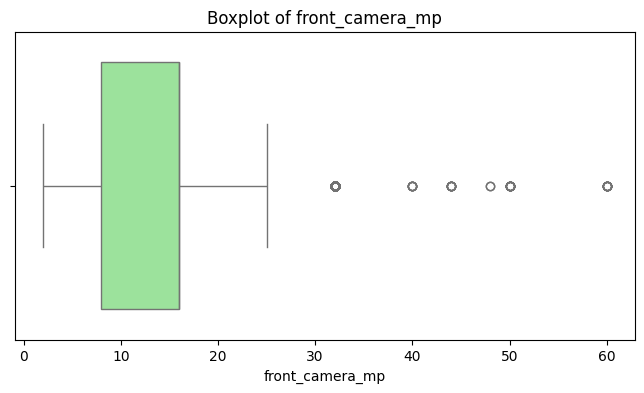

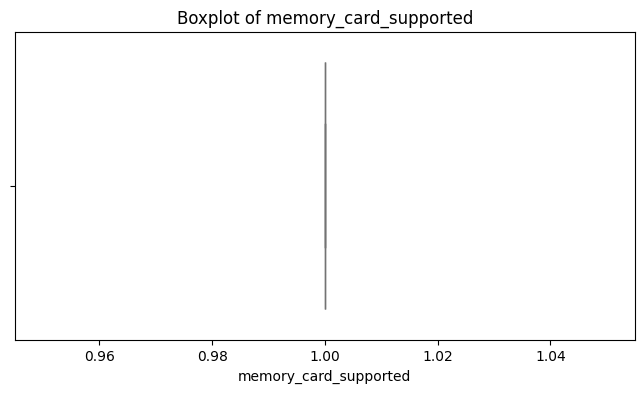

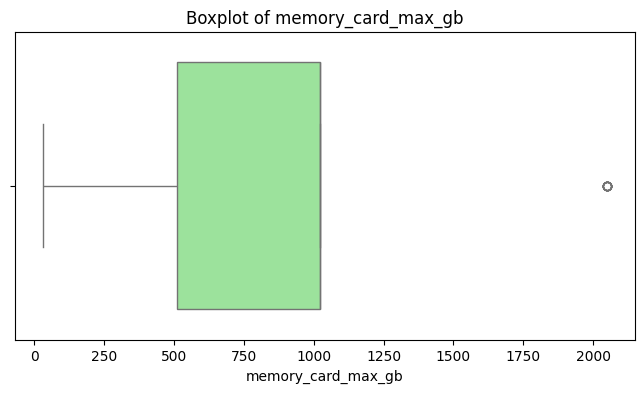

In [16]:
for column in numerical_columns:
    try:        
        plt.figure(figsize=(8,4))
        sns.boxplot(x=df[column], color='lightgreen')
        plt.title(f'Boxplot of {column}')
        plt.xlabel(column)
        plt.show()
    except ImportError:
        print(f"Seaborn not available for plotting {column}")


Extraction Megapixeles and Screen Resolution Processing

In [17]:
def parse_cameras(row):
    try:
        # convert string to real list using ast.literal_eval
        cam_list = ast.literal_eval(row)
        # convert each element to float
        cam_list = [float(c) for c in cam_list]
        return pd.Series([cam_list[0], sum(cam_list)])
    except:
        return pd.Series([0, 0])

In [18]:
# create two new columns primary_rear_mp and total_rear_mp
df[['primary_rear_mp', 'total_rear_mp']] = df['rear_camera_mp_list'].apply(parse_cameras)

In [19]:
def extract_pixels(res_string):
    try:
        # Buscamos los números y los multiplicamos
        parts = res_string.lower().split('x')
        width = int(''.join(filter(str.isdigit, parts[0])))
        height = int(''.join(filter(str.isdigit, parts[1])))
        return width * height
    except:
        return 0

df['total_pixels'] = df['resolution'].apply(extract_pixels)

In [20]:
for columna in ['ram_gb', 'storage_gb']:
    print(f"Unique values in {columna}: {df[columna].unique()}")

Unique values in ram_gb: [ 12   6   4   8   3  16   2  18   1 512]
Unique values in storage_gb: [ 12   6   4   8   3  16   2  18   1 512]


In [21]:
# rename target
df = df.rename(columns={'rating': 'y'})

### 3. Split data(train/validation/test)

Typical split: 60% training, 20% validation and 20% test.

In [22]:
# train test split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

df_train.shape, df_val.shape, df_test.shape

((579, 31), (194, 31), (194, 31))

In [23]:
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

### 4. EDA and Future Engineering
We review correlations and future engineering for the variables.

In [24]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
numerical_columns = list(df.dtypes[df.dtypes != 'object'].index)

In [25]:
df['memory_card_max_gb'].unique()

array([1024.,  512.,  768.,  256., 2048.,  128.,   32.,   80., 1000.,
        320.,   64.])

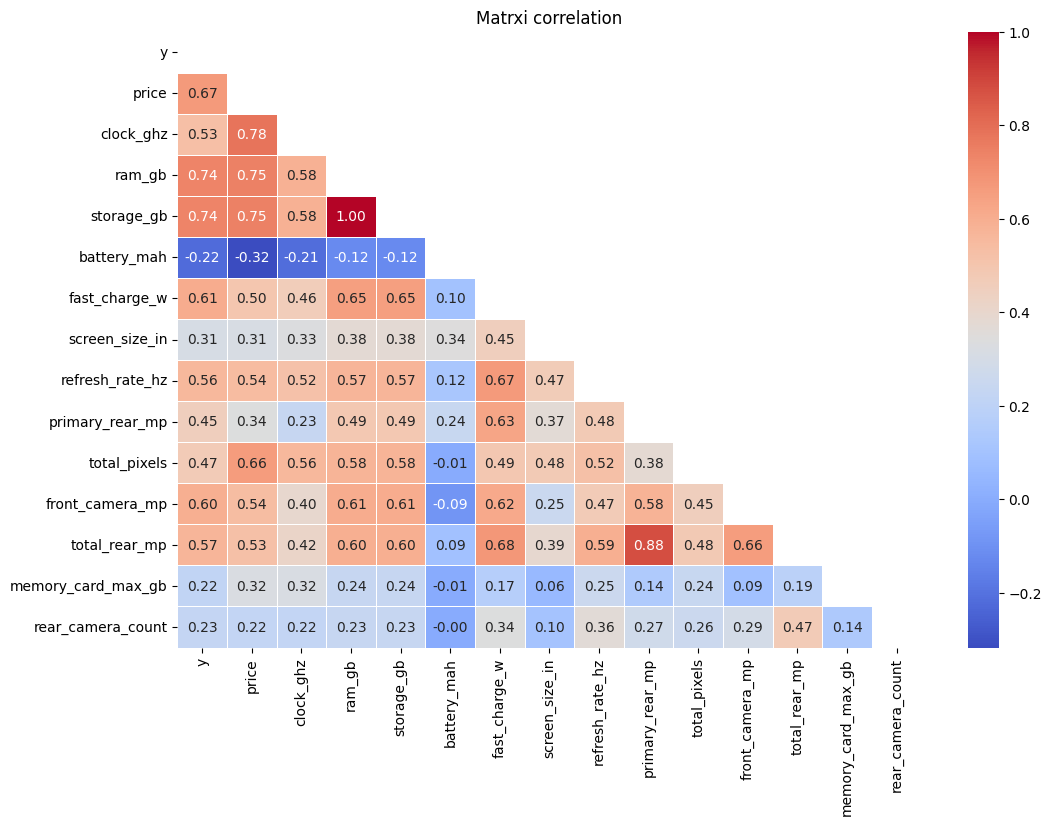

In [26]:
# 1. We select only the numerical columns that make sense for the model
# We exclude IDs or text columns that we have not transformed.
features_to_analyze = [
    'y', 'price', 'clock_ghz', 'ram_gb', 'storage_gb', 
    'battery_mah', 'fast_charge_w', 'screen_size_in', 
    'refresh_rate_hz', 'primary_rear_mp', 'total_pixels', 'front_camera_mp',
    'total_rear_mp', 'memory_card_max_gb', 'rear_camera_count'
]

# 2. We calculate the correlation matrix (Spearman is more robust for non-linear relationships)
corr_matrix = df_train[features_to_analyze].corr(method='spearman')

# 3. We graph
plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Máscara para ver solo la mitad inferior
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matrxi correlation')
plt.show()

In [27]:
# correlation analysis
if 'rating' in numerical_columns:
    numerical_columns.remove('rating')
    numerical_columns.append('y')

x_var = []
y_var = []
correl = []

df_corr = df_train.copy()
for x in df_corr[numerical_columns].corr().index:
    for y in df_corr[numerical_columns].corr().columns:
        if x != y:
            x_var.append(x)
            y_var.append(y)
            correl.append(df_corr[numerical_columns].corr(method='spearman').loc[x, y])

correlation_df = pd.DataFrame({'x': x_var, 'y': y_var, 'correlation': correl})
correlation_df = correlation_df.sort_values(by='correlation', ascending=False)
correlation_df.drop_duplicates(subset=['correlation'], inplace=True)
correlation_df.reset_index(drop=True, inplace=True)
print(correlation_df.head(15))
print('-----------------------')
print(correlation_df.tail(15))

                     x                   y  correlation
0               ram_gb          storage_gb     1.000000
1   rear_camera_max_mp     primary_rear_mp     0.966073
2      primary_rear_mp       total_rear_mp     0.879712
3        total_rear_mp  rear_camera_max_mp     0.852873
4                price           clock_ghz     0.782970
5               ram_gb               price     0.745437
6                    y              ram_gb     0.735432
7        fast_charge_w       total_rear_mp     0.678364
8                  NFC               price     0.676049
9      refresh_rate_hz       fast_charge_w     0.669933
10               price                   y     0.666001
11               price        total_pixels     0.664603
12     front_camera_mp       total_rear_mp     0.660105
13              ram_gb       fast_charge_w     0.653200
14       fast_charge_w  rear_camera_max_mp     0.639655
-----------------------
                      x                      y  correlation
140          ir_blas

In [28]:
# variables correlated
value_corr = 0.7
correlation_df[(abs(correlation_df['correlation']) > value_corr )& (correlation_df['x']!='y')&(correlation_df['x']!='x')]

,x,y,correlation
0,ram_gb,storage_gb,1.000000
1,rear_camera_max_mp,primary_rear_mp,0.966073
2,primary_rear_mp,total_rear_mp,0.879712
3,total_rear_mp,rear_camera_max_mp,0.852873
4,price,clock_ghz,0.782970
5,ram_gb,price,0.745437


There is a correlation grater than 0.6 or less than -0.5, between [storage_gb, ram_gb], [price, clock_ghz], [ram_gb, price ]

/var/folders/s_/5k93dhc10nvdkrdmrkx6yqvr0000gn/T/ipykernel_35874/260949834.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top, x='brand', y='y', palette='viridis')


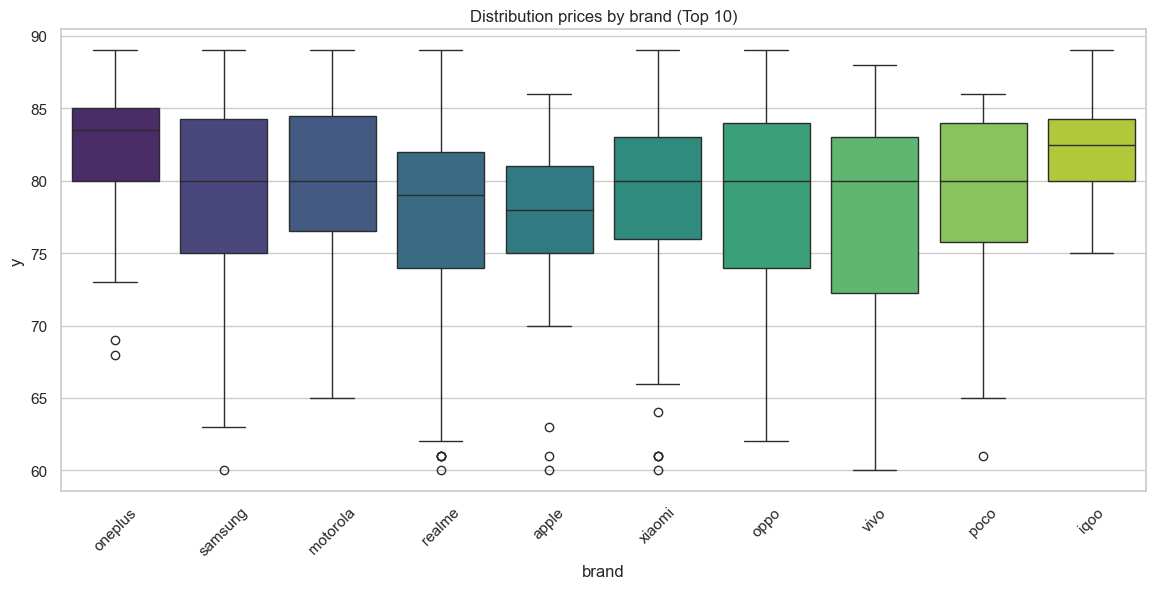

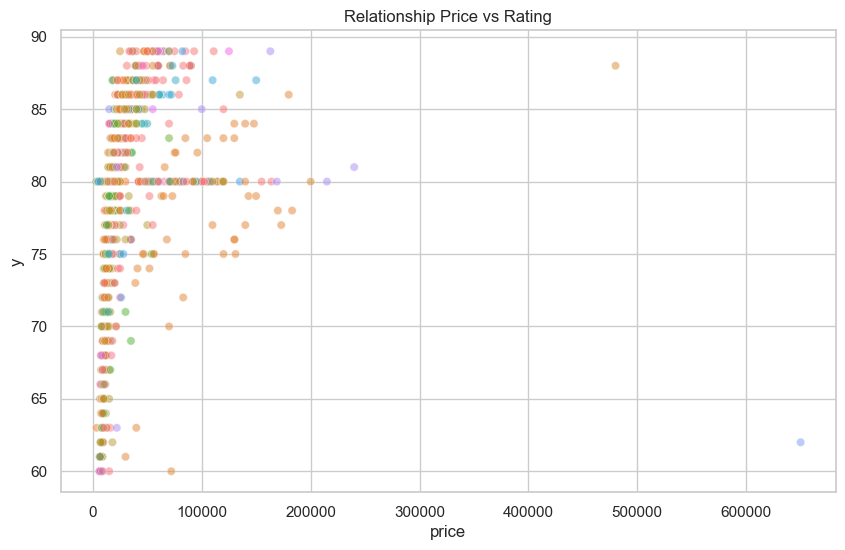

In [29]:
sns.set_theme(style="whitegrid")

# 1. Boxplot price by barnd (Top 10 brands)
top_brands = df['brand'].value_counts().nlargest(10).index
df_top = df[df['brand'].isin(top_brands)]

plt.figure(figsize=(14, 6))
sns.boxplot(data=df_top, x='brand', y='y', palette='viridis')
plt.title('Distribution prices by brand (Top 10)')
plt.xticks(rotation=45)
plt.show()

# 2. Scatter plot Price vs Rating
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='price', y='y', alpha=0.5, hue='brand', legend=False)
plt.title('Relationship Price vs Rating')
plt.show()

In [30]:
# Function to calculate IQR and detect outliers
def detect_outliers_iqr(data, columns):
    outliers = {}
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    return outliers

outliers = detect_outliers_iqr(df_train, features_to_analyze)

# Display the number of outliers in each column
for col, outlier_data in outliers.items():
    print(f"{col}: {len(outlier_data)} outliers detected")

y: 20 outliers detected
price: 65 outliers detected
clock_ghz: 2 outliers detected
ram_gb: 8 outliers detected
storage_gb: 8 outliers detected
battery_mah: 78 outliers detected
fast_charge_w: 12 outliers detected
screen_size_in: 63 outliers detected
refresh_rate_hz: 1 outliers detected
primary_rear_mp: 9 outliers detected
total_pixels: 216 outliers detected
front_camera_mp: 18 outliers detected
total_rear_mp: 16 outliers detected
memory_card_max_gb: 5 outliers detected
rear_camera_count: 12 outliers detected


In [31]:
df_train.columns

Index(['model', 'price', 'y', 'os', 'sim_type', 'network_type', 'VoLTE', 'NFC',
       'ir_blaster', 'chipset', 'core_type', 'clock_ghz', 'ram_gb',
       'storage_gb', 'battery_mah', 'fast_charge_w', 'screen_size_in',
       'resolution', 'refresh_rate_hz', 'display_type', 'rear_camera_mp_list',
       'rear_camera_count', 'rear_camera_max_mp', 'front_camera_mp',
       'memory_card_supported', 'memory_card_type', 'memory_card_max_gb',
       'brand', 'primary_rear_mp', 'total_rear_mp', 'total_pixels'],
      dtype='object')

Pipeline

In [32]:
features_col = [
    'y', 'price', 'storage_gb', 
    'battery_mah', 'fast_charge_w', 'screen_size_in', 
    'refresh_rate_hz', 'primary_rear_mp', 'total_pixels', 
    'front_camera_mp', 'memory_card_max_gb', 'rear_camera_count', 
    'network_type',  'memory_card_type', 'brand'
]

In [33]:
df_aux = df_train[features_col].copy()
# 1. Define columns with preprocessing 
num_features = [
    'price', 'storage_gb', 
    'battery_mah', 'fast_charge_w', 'screen_size_in', 
    'refresh_rate_hz', 'primary_rear_mp', 'total_pixels',
    'front_camera_mp', 'memory_card_max_gb', 'rear_camera_count'
]

cat_features = ['network_type',  'memory_card_type', 'brand']

# 2. Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
    ],
    remainder='passthrough' # Esto deja las columnas booleanas (NFC, VoLTE, etc.) como están
)

# 3. Separaye (X) and Target (y)
X_train = df_aux.drop(['y'], axis=1)
y_train = df_aux['y']

# 4. We adjust and transform (just to see the result, the final Pipeline will do it automatically)
X_train_transformed = preprocessor.fit_transform(X_train)
print(f"Final Matrix shape: {X_train_transformed.shape}")

Final Matrix shape: (579, 53)


In [34]:
df_aux = df_val[features_col].copy()
# 3. Separaye (X) and Target (y)
X_val = df_aux.drop(['y'], axis=1)
y_val = df_aux['y']

# 4. We adjust and transform (just to see the result, the final Pipeline will do it automatically)
X_val_transformed = preprocessor.fit_transform(X_val)
print(f"Final Matrix shape: {X_val_transformed.shape}")

Final Matrix shape: (194, 41)


### 5. Training and model selection

The models trained are:

1. Regression
2. Random Forest
3. XGBoost

Baseline models

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

# Definimos los modelos a probar
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

results = []

# 2. Bucle de entrenamiento y evaluación
for name, model in models.items():
    # Creamos un pipeline completo para cada modelo
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Entrenamos
    pipeline.fit(X_train, y_train)
    
    # Predecimos
    y_pred = pipeline.predict(X_val)
    
    # Evaluamos
    mae = mean_absolute_error(y_val, y_pred)
    rmse = root_mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    results.append({"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2})

# 3. Visualización de resultados

results_df = pd.DataFrame(results).sort_values(by="MAE")
print(results_df)

               Model       MAE      RMSE        R2
2            XGBoost  2.022768  2.710774  0.823705
1      Random Forest  2.190000  3.033436  0.779239
0  Linear Regression  3.500202  4.529378  0.507813


In [36]:
scoring_metrics = {
    'MAE': 'neg_mean_absolute_error',
    'RMSE': 'neg_root_mean_squared_error',
    'R2': 'r2'
}

Tunning Multiple Regression

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

ridge_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

ridge_param_grid = {'regressor__alpha': [0.1, 1.0, 10.0, 100.0]}
ridge_grid = GridSearchCV(ridge_pipe, ridge_param_grid, cv=5, 
    scoring=scoring_metrics, 
    refit='MAE', 
    n_jobs=-1,
    return_train_score=True)
ridge_grid.fit(X_train, y_train)

best_index = ridge_grid.best_index_
best_rmse = abs(ridge_grid.cv_results_['mean_test_RMSE'][best_index])
best_mae = abs(ridge_grid.cv_results_['mean_test_MAE'][best_index])

print(f"Best RF Params: {ridge_grid.best_params_}")
print(f"Resultados del mejor modelo:")
print(f"- MAE: {best_mae:.4f}")
print(f"- RMSE: {best_rmse:.4f}")
print(f"- R2: {ridge_grid.cv_results_['mean_test_R2'][best_index]:.4f}")

Best RF Params: {'regressor__alpha': 1.0}
Resultados del mejor modelo:
- MAE: 3.5476
- RMSE: 4.6184
- R2: 0.5487


Tunning Random Forest

In [39]:
n_estimators_list = list(range(10, 301, 10))
depth_list = [10, 15, 20, 25, 30, None]
min_samples_list = [2, 5, 8, 10, 15]


In [40]:
from sklearn.model_selection import GridSearchCV

# Definimos el Pipeline base
rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Definimos la malla de parámetros (prefijo 'regressor__' para acceder al modelo)
rf_param_grid = {
    'regressor__n_estimators': n_estimators_list,
    'regressor__max_depth': depth_list,
    'regressor__min_samples_split': min_samples_list,
    'regressor__max_features': ['sqrt', 'log2']
}

rf_grid = GridSearchCV(rf_pipe, rf_param_grid, cv=5, 
    scoring=scoring_metrics, 
    refit='MAE', 
    n_jobs=-1,
    return_train_score=True)
rf_grid.fit(X_train, y_train)

best_index = rf_grid.best_index_
best_rmse = abs(rf_grid.cv_results_['mean_test_RMSE'][best_index])
best_mae = abs(rf_grid.cv_results_['mean_test_MAE'][best_index])

print(f"Best RF Params: {rf_grid.best_params_}")
print(f"Resultados del mejor modelo:")
print(f"- MAE: {best_mae:.4f}")
print(f"- RMSE: {best_rmse:.4f}")
print(f"- R2: {rf_grid.cv_results_['mean_test_R2'][best_index]:.4f}")


Best RF Params: {'regressor__max_depth': 20, 'regressor__max_features': 'sqrt', 'regressor__min_samples_split': 2, 'regressor__n_estimators': 20}
Resultados del mejor modelo:
- MAE: 2.5008
- RMSE: 3.6632
- R2: 0.7157


Tunning XGBoost

In [41]:
n_estimators_list = [100, 300, 500]
learning_rate_list = [0.01, 0.05, 0.1, 0.5, 1]
max_depth_list =  [3, 6, 9, 12, 15]
subsample = [0.8, 1.0]

In [42]:
xgb_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42))
])

xgb_param_grid = {
    'regressor__n_estimators': n_estimators_list,
    'regressor__learning_rate': learning_rate_list,
    'regressor__max_depth': max_depth_list,
    'regressor__subsample': subsample
}

xgb_grid = GridSearchCV(xgb_pipe, xgb_param_grid, cv=5, 
    scoring=scoring_metrics, 
    refit='MAE', 
    n_jobs=-1,
    return_train_score=True
)

xgb_grid.fit(X_train, y_train)

# 3. Extraer los resultados del RMSE
# Nota: Los valores vienen en negativo, usamos abs() para que sea legible
best_index = xgb_grid.best_index_
best_rmse = abs(xgb_grid.cv_results_['mean_test_RMSE'][best_index])
best_mae = abs(xgb_grid.cv_results_['mean_test_MAE'][best_index])

print(f"Best RF Params: {xgb_grid.best_params_}")
print(f"Resultados del mejor modelo:")
print(f"- MAE: {best_mae:.4f}")
print(f"- RMSE: {best_rmse:.4f}")
print(f"- R2: {xgb_grid.cv_results_['mean_test_R2'][best_index]:.4f}")

Best RF Params: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 6, 'regressor__n_estimators': 500, 'regressor__subsample': 0.8}
Resultados del mejor modelo:
- MAE: 2.4489
- RMSE: 3.7348
- R2: 0.7042


/var/folders/s_/5k93dhc10nvdkrdmrkx6yqvr0000gn/T/ipykernel_35874/3111420294.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='importance', y='feature', palette='magma')


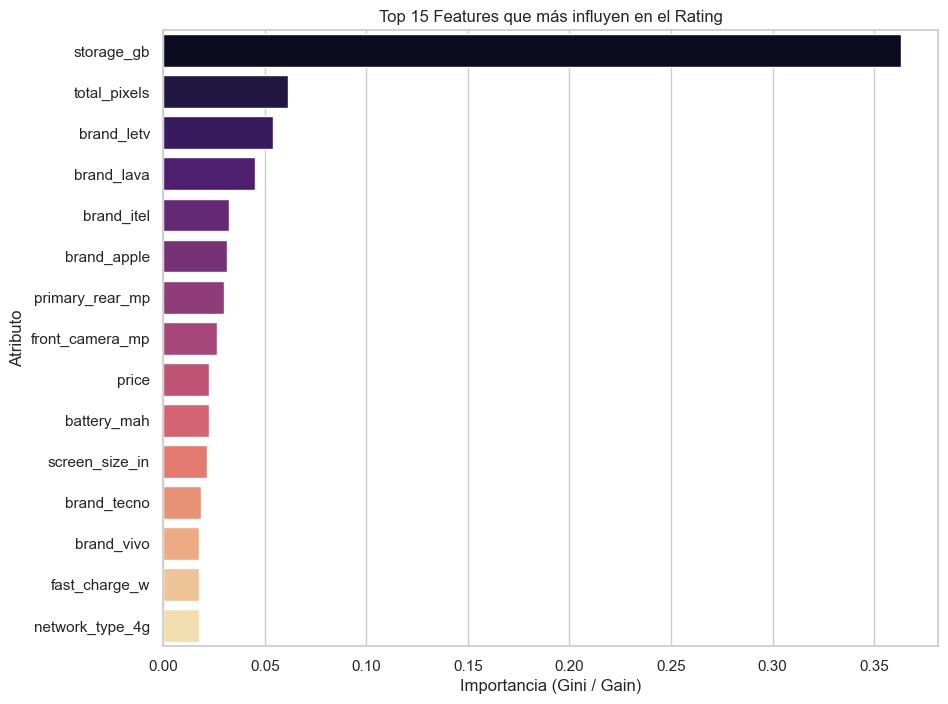

In [43]:
# 1. Recuperar el mejor estimador del GridSearch (asumiendo que xgb_grid fue el mejor)
best_model = xgb_grid.best_estimator_

# 2. Extraer los nombres de las columnas después del preprocesamiento
# Las numéricas mantienen su nombre, las categóricas se expanden por el OneHotEncoder
ohe_feature_names = best_model.named_steps['preprocessor'].named_transformers_['cat']\
    .get_feature_names_out(cat_features)

all_feature_names = num_features + list(ohe_feature_names)

# 3. Crear un DataFrame con las importancias
importances = best_model.named_steps['regressor'].feature_importances_
feature_importance_df = pd.DataFrame({'feature': all_feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False).head(15)

# 4. Graficar
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_df, x='importance', y='feature', palette='magma')
plt.title('Top 15 Features que más influyen en el Rating')
plt.xlabel('Importancia (Gini / Gain)')
plt.ylabel('Atributo')
plt.show()

### 6. Select a Final Model

Best model for MAE

In [122]:
# select features based on previous analysis
num_features = [
    'price', 'storage_gb', 
    'battery_mah', 'fast_charge_w', 'screen_size_in', 
    'refresh_rate_hz', 'primary_rear_mp', 'total_pixels',
    'front_camera_mp', 'memory_card_max_gb', 'rear_camera_count'
]

cat_features = ['network_type',  'memory_card_type', 'brand']

# 2. Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
    ],
    remainder='passthrough' # Esto deja las columnas booleanas (NFC, VoLTE, etc.) como están
)

model = XGBRegressor(n_estimators=500, learning_rate=0.01, max_depth=6, random_state=42)


results = []

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])

# Entrenamos
pipeline.fit(X_train, y_train)

# Predecimos
y_pred = pipeline.predict(X_val)

# Evaluamos
mae = mean_absolute_error(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

results.append({"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2})

# 3. Visualización de resultados
import pandas as pd
results_df = pd.DataFrame(results).sort_values(by="MAE")
print(results_df)

     Model       MAE     RMSE        R2
0  XGBoost  2.028646  2.67513  0.828311


### 7. Final model evalluation

In [44]:
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = df_full_train.y.values
df_full_train.drop(['y'], axis=1, inplace=True)

y_test = df_test.y.values
df_test.drop(['y'], axis=1, inplace=True)

In [45]:
feature_selection = [
    'price', 'storage_gb', 
    'battery_mah', 'fast_charge_w', 'screen_size_in', 
    'refresh_rate_hz', 'primary_rear_mp', 'total_pixels', 
    'front_camera_mp', 'memory_card_max_gb', 'rear_camera_count', 
    'network_type',  'memory_card_type', 'brand'
]

In [46]:
# select features based on previous analysis
num_features = [
    'price', 'storage_gb', 
    'battery_mah', 'fast_charge_w', 'screen_size_in', 
    'refresh_rate_hz', 'primary_rear_mp', 'total_pixels',
    'front_camera_mp', 'memory_card_max_gb', 'rear_camera_count'
]

cat_features = ['network_type',  'memory_card_type', 'brand']

# 2. Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
    ],
    remainder='passthrough' # Esto deja las columnas booleanas (NFC, VoLTE, etc.) como están
)

# parameters
n_estimators=500
learning_rate=0.01
max_depth=6

model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
                    max_depth=max_depth, random_state=42)

X_full_train = df_full_train[feature_selection]
X_test = df_test[feature_selection]

results = []

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])

# Entrenamos
pipeline.fit(X_full_train, y_full_train)

# Predecimos
y_pred = pipeline.predict(X_test)

# Evaluamos
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

results.append({"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2})

# 3. Visualización de resultados
import pandas as pd
results_df = pd.DataFrame(results).sort_values(by="MAE")
print(results_df)

     Model       MAE      RMSE       R2
0  XGBoost  2.322967  3.838141  0.73235


In [1]:
import requests

url = 'http://localhost:9696/predict'
cell = {'model': 'oneplus 11 5g',
 'price': 54999,
 'rating': 89.0,
 'os': 'Android v13',
 'sim_type': 'Dual',
 'network_type': '5g',
 'VoLTE': True,
 'NFC': True,
 'ir_blaster': False,
 'chipset': 'Snapdragon 8 Gen2',
 'core_type': 'Octa Core',
 'clock_ghz': 3.2,
 'ram_gb': 12,
 'storage_gb': 12,
 'battery_mah': 5000.0,
 'fast_charge_w': 100.0,
 'screen_size_in': 6.7,
 'resolution': '1440x3216',
 'refresh_rate_hz': 120.0,
 'display_type': 'Punch Hole',
 'rear_camera_mp_list': '[50, 48, 32]',
 'rear_camera_count': 3,
 'rear_camera_max_mp': 50.0,
 'front_camera_mp': 16.0,
 'memory_card_supported': 1,
 'memory_card_type': 'nan',
 'memory_card_max_gb': 'nan'
}

response = requests.post(url, json=cell).json()
print(response)

{'cell_score_prediction': 84.61000061035156}
